In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pystan
import pymc

%matplotlib inline  
plt.style.use('ggplot')

N = 100
M = 3

mu_t = [10, 9, 8]
sigma_t = [2, 1.8, 1.6]

mu_c = [9, 8, 7]
sigma_c = [1.3, 1.2, 1.1]

Xc = np.zeros((M, N))
Xt = np.zeros((M, N))


for i in range(M):
    Xt[i, :] = mu_t[i] + sigma_t[i]*np.random.randn(N)
    Xc[i, :] = mu_c[i] + sigma_c[i]*np.random.randn(N) 

In [31]:
anova_code = """

data {
    int<lower=0> N; // number of samples per group
    int<lower=0> M; // number of groups

    matrix<lower=0>[M, N] Xt; // treatment groups feature values
    matrix<lower=0>[M, N] Xc; // control groups feature values
}

parameters {
    real<lower=0> mu_t[M]; // treatment groups mean
    real<lower=0> mu_c[M]; // control groups mean
    
    real<lower=0> sigma_t[M]; // treatment groups stddev
    real<lower=0> sigma_c[M]; // control groups stddev
    
    real<lower=0> mu_T; // generic treatment group mean
    real<lower=0> sigma_T; // generic treatment group stddev

    real<lower=0> mu_C; // generic control group mean
    real<lower=0> sigma_C; // generic control group stddev

    real<lower=0> mu_ST; // generic treatment group stddev mean
    real<lower=0> sigma_ST; // generic treatment group stddev stddev

    real<lower=0> mu_SC; // generic control group stddev mean
    real<lower=0> sigma_SC; // generic control group stddev stddev
}


model {
    // Likelihoods
    for (i in 1:M) {
        Xt[i, :] ~ normal(mu_t[i], sigma_t[i]);
        Xc[i, :] ~ normal(mu_c[i], sigma_c[i]);
    }
    
    // Priors
    mu_t ~ cauchy(mu_T, sigma_T);
    mu_c ~ cauchy(mu_C, sigma_C);
    sigma_t ~ cauchy(mu_ST, sigma_ST);
    sigma_c ~ cauchy(mu_SC, sigma_SC);
    
    // Hyperpriors
    mu_T ~ cauchy(0, 5);
    sigma_T ~ cauchy(0, 5);
    mu_C ~ cauchy(0, 5);
    sigma_C ~ cauchy(0, 5);
    mu_ST ~ cauchy(0, 5);
    sigma_ST ~ cauchy(0, 5);
    mu_SC ~ cauchy(0, 5);
    sigma_SC ~ cauchy(0, 5);
}
"""

# dictionary containing data
data = {
    'N': N,
    'M': M,
    'Xt': Xt,
    'Xc': Xc
}


# fit model
fit = pystan.stan(model_code=anova_code, data=data, iter=2000, chains=4)
print(fit)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f1ce2a9bce994c78af76ec04e1538c46 NOW.


Inference for Stan model: anon_model_f1ce2a9bce994c78af76ec04e1538c46.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu_t[0]     10.01  5.0e-3   0.21   9.58   9.87  10.01  10.15  10.41   1829    1.0
mu_t[1]       9.1  3.0e-3   0.17   8.77   8.98    9.1   9.22   9.43   3145    1.0
mu_t[2]      7.91  2.8e-3   0.16    7.6   7.81    7.9   8.02   8.23   3236    1.0
mu_c[0]       8.8  2.9e-3   0.15   8.52   8.71    8.8    8.9   9.08   2466    1.0
mu_c[1]      8.02  2.0e-3   0.11   7.79   7.94   8.02    8.1   8.24   3342    1.0
mu_c[2]       6.9  2.0e-3   0.11   6.68   6.83    6.9   6.97   7.12   3081    1.0
sigma_t[0]   2.08  3.1e-3   0.15   1.81   1.97   2.07   2.18    2.4   2420    1.0
sigma_t[1]   1.67  2.3e-3   0.12   1.46   1.59   1.67   1.74   1.91   2451    1.0
sigma_t[2]   1.61  2.3e-3   0.12    1.4   1.53   1.61   1.69   1.85   263

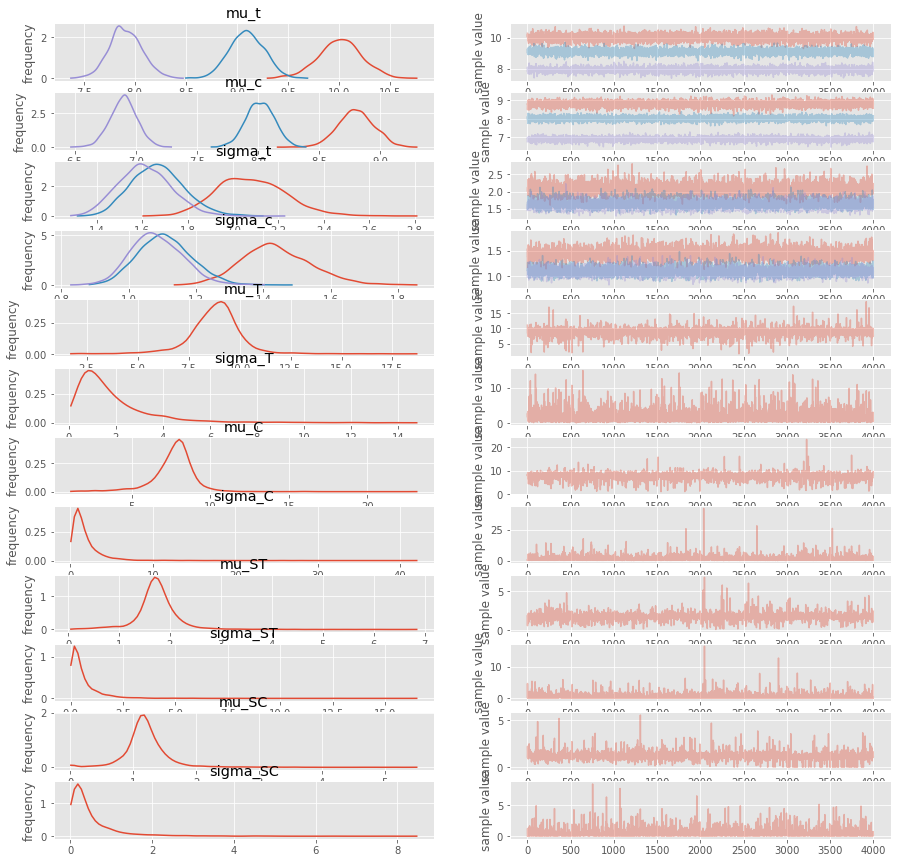

In [33]:
fig = fit.plot()
fig.set_size_inches(15, 15)

In [34]:
mu_t = fit.extract('mu_T')['mu_T']
mu_c = fit.extract('mu_C')['mu_C']

print((mu_t > mu_c).mean())

0.7595
